# Approximating the Hessian for large neural networks.

This notebook describes how to use the spectral-density package with Tensorflow2. The main entry point of this package is the `lanczos_algorithm.approximate_hessian` function, compatible with Keras models. This function takes the following arguments:

  - `model`: The Keras model for which we want to compute the Hessian.
  - `dataset`: Dataset on which the model is trained. Can be a Tensorflow dataset, or more generally any iterator yielding tuples of data (X, y). If a Tensorflow dataset is used, it should be batched beforehand.
  - `order`: Rank of the approximation of the Hessian. The higher the better the approximation. See paper for more details.
  - `reduce_op`: Whether the loss function averages or sums the per sample loss. The default value is `MEAN` and should be compatible with most Keras losses, provided you didn't specify another reduction when instantiating it.
  - `random_seed`: Seed to use to sample the first vector in the Lanczos algorithm.

## Example 1: Full rank estimation for linear model.

We start with a simplistic usecase: we wish to train the following model:

$$ \mbox{arg}\max_\beta \sum_i (y_i - \beta^Tx_i)^2$$

As this optimization problem is quadratic, the Hessian of the loss is independent of $\beta$ and is equal to $2X^TX$. Let's verify this using `lanczos_algorithm.approximate_hessian`, and setting the order of the approximation to the number of features, thus recovering the exact Hessian.

We first generate some random inputs and outputs:

In [0]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import seaborn as sns
tf.enable_v2_behavior()

import lanczos_algorithm

In [0]:
num_samples = 50
num_features = 16
X = tf.random.normal([num_samples, num_features])
y = tf.random.normal([num_samples])

We then define a linear model using the Keras API:

In [0]:
linear_model = tf.keras.Sequential(
    [tf.keras.Input(shape=[num_features]),
     tf.keras.layers.Dense(1, use_bias=False)])

Finally, we define a loss function that takes as input the model and a batch of examples, and return a scalar loss. Here, we simply compute the mean squared error between the predictions of the model and the desired output. 

In [0]:
def loss_fn(model, inputs):
  x, y = inputs
  preds = linear_model(x)
  return tf.keras.losses.mse(y, preds)

Fnally, we call `approximate_hessian`, setting order to the number of parameters to compute the exact Hessian. This function returns two tensors $(V, T)$ of shapes (num_parameters, order) and (order, order), such that :
$$ H \approx V T V^T $$
with an equality if order = num_parameters.

In [6]:
V, T = lanczos_algorithm.approximate_hessian(
        linear_model,
        loss_fn,
        [(X,y)],
        order=num_features)

Iteration 0/16 done in 1.85s (MVP: 1.85s).
Iteration 1/16 done in 0.08s (MVP: 0.07s).
Iteration 2/16 done in 0.07s (MVP: 0.07s).
Iteration 3/16 done in 0.07s (MVP: 0.07s).
Iteration 4/16 done in 0.07s (MVP: 0.07s).
Iteration 5/16 done in 0.07s (MVP: 0.07s).
Iteration 6/16 done in 0.07s (MVP: 0.07s).
Iteration 7/16 done in 0.07s (MVP: 0.07s).
Iteration 8/16 done in 0.07s (MVP: 0.07s).
Iteration 9/16 done in 0.08s (MVP: 0.07s).
Iteration 10/16 done in 0.08s (MVP: 0.07s).
Iteration 11/16 done in 0.07s (MVP: 0.06s).
Iteration 12/16 done in 0.07s (MVP: 0.07s).
Iteration 13/16 done in 0.07s (MVP: 0.07s).
Iteration 14/16 done in 0.08s (MVP: 0.07s).
Iteration 15/16 done in 0.07s (MVP: 0.07s).


We can check that the reconstructed Hessian is indeed equal to $2X^TX$:

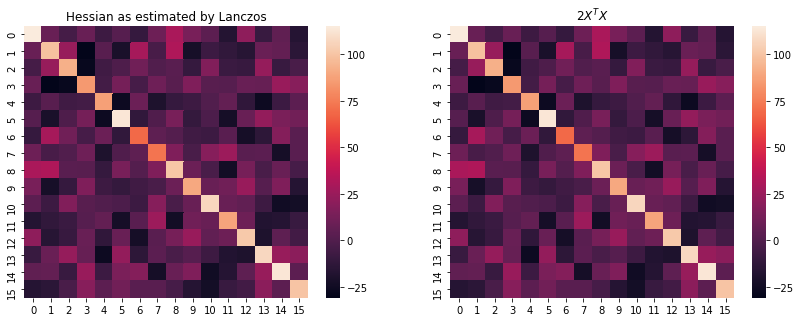

In [7]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
H = tf.matmul(V, tf.matmul(T, V, transpose_b=True))
plt.title("Hessian as estimated by Lanczos")
sns.heatmap(H)
plt.subplot(1,2,2)
plt.title("$2X^TX$")
sns.heatmap(2 * tf.matmul(X, X, transpose_a=True))
plt.show()

## Example 2: Convnet on Cifar10

We first define a VGG16-like model (15.2M parameters) that we train a bit on Cifar10:

In [57]:
def preprocess_images(tfrecord):
  image, label = tfrecord['image'], tfrecord['label']
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

cifar_dataset_train = tfds.load("cifar10", split="train").map(preprocess_images).cache()
cifar_dataset_test = tfds.load("cifar10", split="test").map(preprocess_images).cache()

model = tf.keras.Sequential([
  tf.keras.Input([32, 32, 3]),
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(10)])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(model.summary())

_ = model.fit(cifar_dataset_train.batch(32),
              validation_data=cifar_dataset_test.batch(128),
              epochs=5)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 10, 10, 128)       147584    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3200)            

Our loss function is a bit different from the previous one, as we now use cross-entropy to train our model. Don't forget to set `training=False` to deactivate dropouts and similar mechanisms.
 
Computing an estimation of the Hessian will take a bit of time. A good rule of thumb is that the algorithm will take $T = order \times 2 T_{epoch}$ units of time, where $T_{epoch}$ stands for the time needed to perform one training epoch.

In [67]:
SCCE = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_fn(model, inputs):
  x, y = inputs
  preds = model(x, training=False)
  return SCCE(y, preds)

V, T = lanczos_algorithm.approximate_hessian(
        model,
        loss_fn,
        mnist_dataset.batch(128),
        order=90,
        random_seed=1)

Iteration 0/90 done in 8.42s (MVP: 8.42s).
Iteration 1/90 done in 8.25s (MVP: 8.23s).
Iteration 2/90 done in 8.28s (MVP: 8.26s).
Iteration 3/90 done in 8.29s (MVP: 8.26s).
Iteration 4/90 done in 8.27s (MVP: 8.23s).
Iteration 5/90 done in 8.29s (MVP: 8.24s).
Iteration 6/90 done in 8.31s (MVP: 8.24s).
Iteration 7/90 done in 8.41s (MVP: 8.34s).
Iteration 8/90 done in 8.37s (MVP: 8.28s).
Iteration 9/90 done in 8.34s (MVP: 8.24s).
Iteration 10/90 done in 8.32s (MVP: 8.21s).
Iteration 11/90 done in 8.35s (MVP: 8.23s).
Iteration 12/90 done in 8.40s (MVP: 8.27s).
Iteration 13/90 done in 8.39s (MVP: 8.24s).
Iteration 14/90 done in 8.41s (MVP: 8.26s).
Iteration 15/90 done in 8.42s (MVP: 8.25s).
Iteration 16/90 done in 8.50s (MVP: 8.33s).
Iteration 17/90 done in 8.41s (MVP: 8.22s).
Iteration 18/90 done in 8.40s (MVP: 8.21s).
Iteration 19/90 done in 8.44s (MVP: 8.24s).
Iteration 20/90 done in 8.46s (MVP: 8.24s).
Iteration 21/90 done in 8.49s (MVP: 8.26s).
Iteration 22/90 done in 8.48s (MVP: 8.24s)

Finally, you can use the visualization functions provided in `jax.density` to plot the spectum (no actual JAX code is involved in this operation).

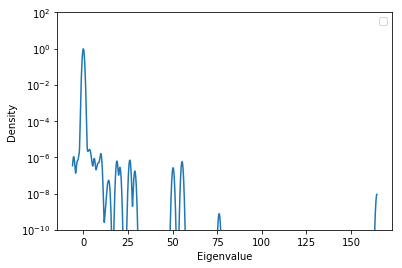

In [64]:
import ..jax.density as density_lib

def plot(grids, density, label=None):
  plt.semilogy(grids, density, label=label)
  plt.ylim(1e-10, 1e2)
  plt.ylabel("Density")
  plt.xlabel("Eigenvalue")
  plt.legend()

density, grids = density_lib.tridiag_to_density(
    [T.numpy()], grid_len=10000, sigma_squared=1e-3)

plot(grids, density)